In [1]:
import numpy as np
import pandas as pd

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv
from scipy.special import jn_zeros
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_3D(a, mu, ndt, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta1 = np.arctan2(np.sqrt(x[2]**2 + x[1]**2), x[0])
    theta2 = np.arctan2(x[2], x[1])   
    
    return rt+ndt, (theta1, theta2)

In [3]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
    term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
    term3 = da(t) - (a(t)/(t-tau)) + kk
    term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q)

        for j in range(1, n):
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [4]:
def HSDM_3D_likelihood(prms, RT, Theta):
    a = lambda t: prms[0]**2
    da = lambda t: 0
    ndt = prms[1]
    mu = np.array([prms[2], prms[3], prms[4]])
    
    fpt = ie_bessel_fpt(a, da, mu.shape[0], 0.001, 
                        dt=0.01, T_max=max(RT))
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.001:
            mu_dot_x0 = mu[0]*np.cos(theta[0])
            mu_dot_x1 = mu[1]*np.sin(theta[0])*np.cos(theta[1]) 
            mu_dot_x2 = mu[2]*np.sin(theta[0])*np.sin(theta[1])
            term1 = prms[0] * (mu_dot_x0 + mu_dot_x1 + mu_dot_x2)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt-ndt)
            
            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            if 0.1**14 < density:
                log_lik += -np.log(density)
            else:
                log_lik += -np.log(0.1**14)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [5]:
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu1_true': [],
               'mu1_estimate': [],
               'mu2_true': [],
               'mu2_estimate': [],
               'mu3_true': [],
               'mu3_estimate': []}

min_threshold = 0.5
max_threshold = 2.5

min_ndt = 0.1
max_ndt = 1

min_mu = -3.5
max_mu = 3.5

In [6]:
for n in range(150):
    threshold = np.random.uniform(min_threshold, max_threshold)
    a = lambda t: threshold
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu),
                   np.random.uniform(min_mu, max_mu)])
    
    
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu1_true'].append(mu[0])
    recovery_df['mu2_true'].append(mu[1])
    recovery_df['mu3_true'].append(mu[2])
    
    RT = []
    Theta = []
    
    print(n+1, end=': ')
    for i in range(250):
        rt, theta = simulate_HSDM_3D(a, mu, ndt)
        RT.append(rt)
        Theta.append(theta)
    
    print('Simulation is done!', end=' / ')
    
    min_ans = minimize(HSDM_3D_likelihood,
                       args=(RT, Theta), 
                       x0=np.array([np.random.uniform(min_threshold, max_threshold),
                                    np.random.uniform(min_ndt, max_ndt), 
                                    np.random.uniform(min_mu, max_mu),
                                    np.random.uniform(min_mu, max_mu),
                                    np.random.uniform(min_mu, max_mu)]),
                       method='Nelder-Mead', 
                       bounds=[(min_threshold, max_threshold), (min_ndt, max_ndt),
                               (min_mu, max_mu), (min_mu, max_mu), (min_mu, max_mu)])
    
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu1_estimate'].append(min_ans.x[2])
    recovery_df['mu2_estimate'].append(min_ans.x[3])
    recovery_df['mu3_estimate'].append(min_ans.x[4])
    
    print('Estimation is done!')
    
recovery_df = pd.DataFrame(recovery_df)

1: Simulation is done! / Estimation is done!
2: Simulation is done! / Estimation is done!
3: Simulation is done! / Estimation is done!
4: Simulation is done! / Estimation is done!
5: Simulation is done! / Estimation is done!
6: Simulation is done! / Estimation is done!
7: Simulation is done! / Estimation is done!
8: Simulation is done! / Estimation is done!
9: Simulation is done! / Estimation is done!
10: Simulation is done! / Estimation is done!


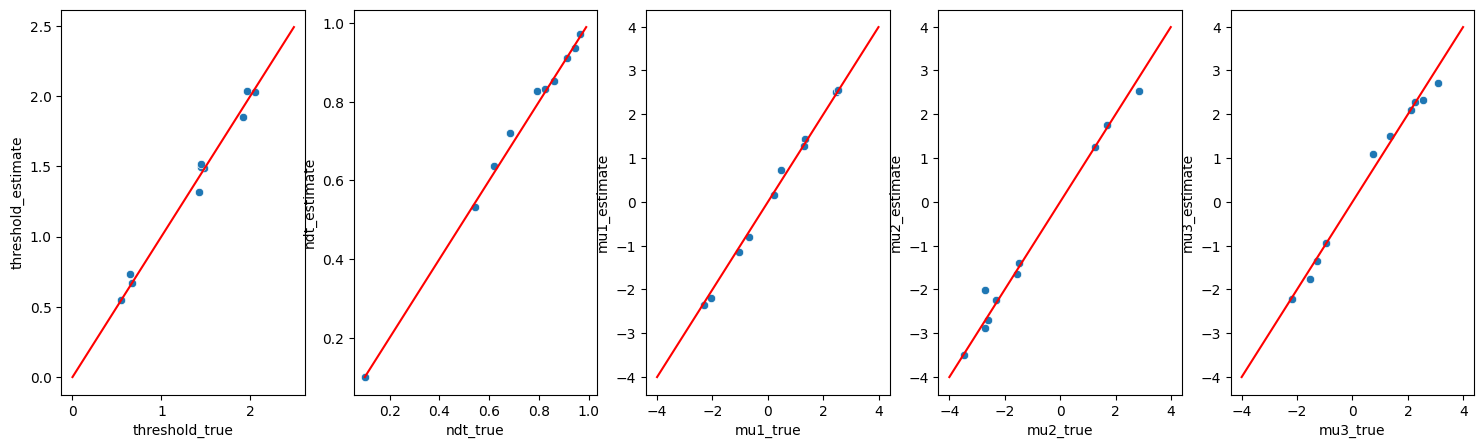

In [12]:
plt.figure(figsize=(22, 5))

plt.subplot(161)
plt.plot(np.arange(0, 2.5, 0.01), np.arange(0, 2.5, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df);

plt.subplot(162)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);

plt.subplot(163)
plt.plot(np.arange(-4, 4, 0.01), np.arange(-4, 4, 0.01), c='red')
sns.scatterplot(x='mu1_true', y='mu1_estimate', data=recovery_df);

plt.subplot(164)
plt.plot(np.arange(-4, 4, 0.01), np.arange(-4, 4, 0.01), c='red')
sns.scatterplot(x='mu2_true', y='mu2_estimate', data=recovery_df);

plt.subplot(165)
plt.plot(np.arange(-4, 4, 0.01), np.arange(-4, 4, 0.01), c='red')
sns.scatterplot(x='mu3_true', y='mu3_estimate', data=recovery_df);

In [8]:
recovery_df

,threshold_true,threshold_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,mu3_true,mu3_estimate
0,1.422228,1.314907,0.793608,0.828666,1.326225,1.441955,1.244240,1.249905,-2.182960,-2.218829
1,2.054512,2.029502,0.685424,0.720694,0.468376,0.719451,-3.461387,-3.499991,1.352060,1.500706
2,1.479620,1.484859,0.542122,0.532334,1.310638,1.286174,-2.303278,-2.230740,2.545409,2.324196
3,0.645471,0.731638,0.944250,0.937250,-2.055214,-2.184909,1.683889,1.763593,2.111058,2.102750
4,0.547070,0.551663,0.912362,0.912362,2.445735,2.511370,-2.706012,-2.019218,0.757211,1.087868
5,1.448953,1.491797,0.102677,0.100004,-2.300429,-2.353268,-2.615920,-2.703339,3.095698,2.703865
6,0.669863,0.668959,0.966242,0.971243,0.213232,0.160334,2.832352,2.523192,-1.528256,-1.765515
7,1.960119,2.038639,0.861321,0.853310,-0.695995,-0.801994,-1.549857,-1.644664,-1.286687,-1.348082
8,1.449974,1.512620,0.825407,0.832929,-1.046707,-1.154728,-2.698724,-2.868983,-0.965349,-0.942752
9,1.914832,1.847927,0.619230,0.635761,2.520221,2.546108,-1.502456,-1.404783,2.264488,2.279666


In [13]:
recovery_df.to_csv('IE_3d_recovery.csv')